Taken from https://docs.scvi-tools.org/en/stable/tutorials/notebooks/harmonization.html

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import scvi

Global seed set to 0


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
sc.set_figure_params(dpi=100, frameon=False, color_map='Reds')
sc.logging.print_header()

/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/scanpy/_settings.py:447: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)
2021-10-18 08:38:42.136801: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-10-18 08:38:42.136851: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


scanpy==1.8.0 anndata==0.7.6 umap==0.5.1 numpy==1.19.2 scipy==1.6.2 pandas==1.3.3 scikit-learn==0.23.2 statsmodels==0.11.1 python-igraph==0.8.3 leidenalg==0.8.3 pynndescent==0.5.5


In [4]:
covid = sc.read('/storage/groups/ml01/workspace/yuge.ji/covid-perturbation/data/210118_annot_patient_all.h5ad')
covid

AnnData object with n_obs × n_vars = 300353 × 18115
    obs: 'identifier', 'patient', 'name', 'barcode_round', 'sample', 'viral_counts', 'treatment', 'treatment_virus', 'infected', 'n_counts', 'n_genes', 'percent_mito', 'percent_viral', 'leiden', 'final_bcs', 'batch', 'celltype_coarse', 'cell_type', 'infection_label'
    obsm: 'X_pca', 'X_umap'
    layers: 'counts'

In [5]:
fischer = sc.read('/storage/groups/ml01/datasets/projects/20201130_Schober_TcellReversePhenotyping_meshal.ansari/201209_TcellReversePT_integrated.h5ad')
fischer.obs['cell_type'] = ['('.join(s.split('(')[:-1])[:-1] for s in fischer.obs['harmonized_celltype'].values]
fischer

AnnData object with n_obs × n_vars = 279663 × 46190
    obs: 'patients', 'sample_ID', 'data_set', 'severity', 'location', 'condition', 'age', 'sex', 'virus_positive', 'PBMC_leiden_29', 'patient_category', 'reactive_clonotype', 'published_meta_celltype', 'published_celltype', 'harmonized_celltype', 'T_cell_type', 'size_factors', 'pct_mitochondrial', 'n_counts', 'n_genes', 'cell_type'
    var: 'highly_variable'
    uns: 'PBMC_leiden_29_colors', 'T_cell_type_colors', 'condition_colors', 'data_set_colors', 'harmonized_celltype_colors', 'leiden_colors', 'location_colors', 'name_colors', 'neighbors', 'patient_category_colors', 'patient_colors', 'patients_colors', 'pca', 'published_celltype_colors', 'reactive_colors', 'sample_colors', 'second_harmonized_colors', 'severity_TA_colors', 'severity_colors', 'severity_condition_colors', 'umap', 'virus_positive_colors'
    obsm: 'X_clonotype_network', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'unsouped_counts'
    obsp: 'connectivities

## Data processing

Remove cells without a treament label and subsample to decrease runtime.

In [6]:
covid = covid[~covid.obs.treatment.isin(['nan', 'mock'])]
covid = covid.concatenate(sc.pp.subsample(covid[covid.obs.treatment == 'mock'], .3, copy=True))
covid

AnnData object with n_obs × n_vars = 190722 × 18115
    obs: 'identifier', 'patient', 'name', 'barcode_round', 'sample', 'viral_counts', 'treatment', 'treatment_virus', 'infected', 'n_counts', 'n_genes', 'percent_mito', 'percent_viral', 'leiden', 'final_bcs', 'batch', 'celltype_coarse', 'cell_type', 'infection_label'
    obsm: 'X_pca', 'X_umap'
    layers: 'counts'

/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'cell_type' as categorical


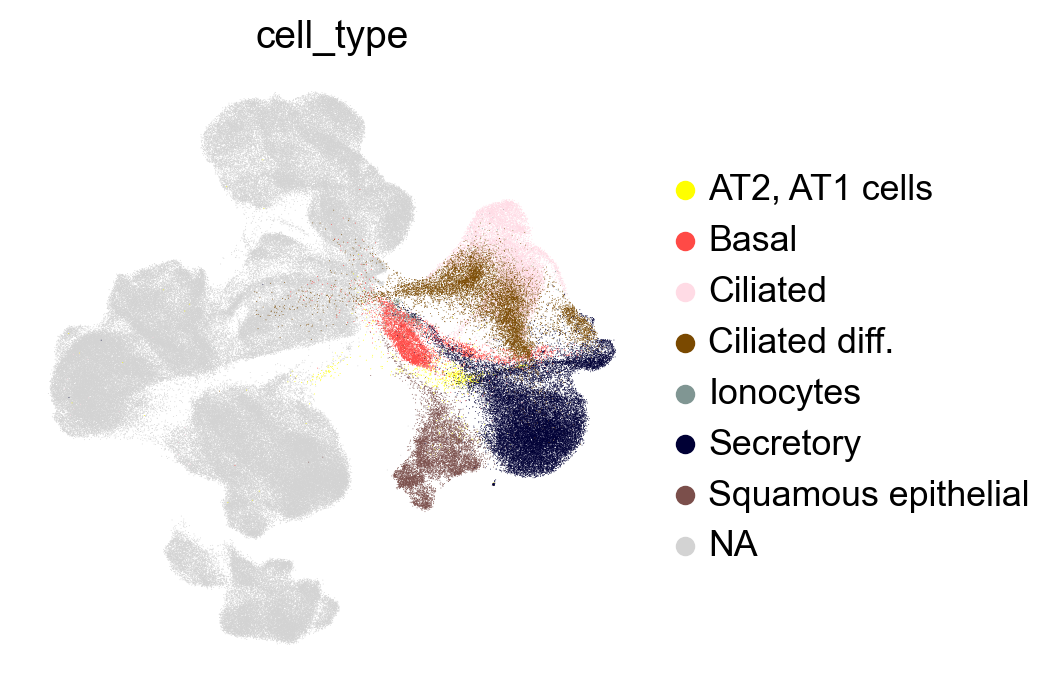

In [7]:
sc.pl.umap(
    fischer, 
    color='cell_type',
    groups=['Ciliated', 'Ciliated diff.', 'Basal', 'Ionocytes', 'Squamous epithelial', 'Secretory', 'AT2, AT1 cells']
)

In [8]:
fischer = fischer[fischer.obs.cell_type.isin(['Ciliated', 'Ciliated diff.', 'Basal', 'Ionocytes', 'Squamous epithelial', 'Secretory', 'AT2, AT1 cells'])]
fischer

View of AnnData object with n_obs × n_vars = 62326 × 46190
    obs: 'patients', 'sample_ID', 'data_set', 'severity', 'location', 'condition', 'age', 'sex', 'virus_positive', 'PBMC_leiden_29', 'patient_category', 'reactive_clonotype', 'published_meta_celltype', 'published_celltype', 'harmonized_celltype', 'T_cell_type', 'size_factors', 'pct_mitochondrial', 'n_counts', 'n_genes', 'cell_type'
    var: 'highly_variable'
    uns: 'PBMC_leiden_29_colors', 'T_cell_type_colors', 'condition_colors', 'data_set_colors', 'harmonized_celltype_colors', 'leiden_colors', 'location_colors', 'name_colors', 'neighbors', 'patient_category_colors', 'patient_colors', 'patients_colors', 'pca', 'published_celltype_colors', 'reactive_colors', 'sample_colors', 'second_harmonized_colors', 'severity_TA_colors', 'severity_colors', 'severity_condition_colors', 'umap', 'virus_positive_colors', 'cell_type_colors'
    obsm: 'X_clonotype_network', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'unsouped_counts

Harmonized cell type names.

In [9]:
fischer.obs['cell_type'] = [s.lower() for s in fischer.obs['cell_type']]

Trying to set attribute `.obs` of view, copying.


Label batches.

In [10]:
fischer.obs['batch_data'] = 'fischer'
covid.obs['batch_data'] = covid.obs['patient']

In [11]:
adata = covid.concatenate(fischer)
adata.obs.batch_data.value_counts()

patient_4    71626
patient_3    62830
fischer      62326
patient_1    35778
patient_2    20488
Name: batch_data, dtype: int64

In [12]:
adata.X = adata.layers['counts']
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=2000,
    batch_key="batch_data",
    subset=True
)
adata

/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'identifier' as categorical
/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'patient' as categorical
/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecat

AnnData object with n_obs × n_vars = 253048 × 2000
    obs: 'identifier', 'patient', 'name', 'barcode_round', 'sample', 'viral_counts', 'treatment', 'treatment_virus', 'infected', 'n_counts', 'n_genes', 'percent_mito', 'percent_viral', 'leiden', 'final_bcs', 'batch', 'celltype_coarse', 'cell_type', 'infection_label', 'batch_data', 'patients', 'sample_ID', 'data_set', 'severity', 'location', 'condition', 'age', 'sex', 'virus_positive', 'PBMC_leiden_29', 'patient_category', 'reactive_clonotype', 'published_meta_celltype', 'published_celltype', 'harmonized_celltype', 'T_cell_type', 'size_factors', 'pct_mitochondrial'
    var: 'highly_variable-1', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg'
    obsm: 'X_pca', 'X_umap'
    layers: 'counts'

In [13]:
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="batch_data")

INFO     Using batches from adata.obs["batch_data"]                                          
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["counts"]                                              
INFO     Successfully registered anndata object containing 253048 cells, 2000 vars, 5        
         batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


## scVI integration

In [14]:
vae = scvi.model.SCVI(adata, n_layers=2, n_latent=30)

/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/scvi/model/base/_base_model.py:151: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  "Make sure the registered X field in anndata contains unnormalized count data."


In [ ]:
vae.train()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Epoch 1/32:   0%|                                                                                                                                                                                                                    | 0/32 [00:00<?, ?it/s]

/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/scvi/distributions/_negative_binomial.py:435: UserWarning: The value argument must be within the support of the distribution
  UserWarning,


Epoch 15/32:  44%|████████████████████████████████████████████████████████████████████████████████                                                                                                       | 14/32 [09:15<11:47, 39.31s/it, loss=459, v_num=1]

In [ ]:
adata.obsm["X_scVI"] = vae.get_latent_representation()

In [ ]:
%%time
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.leiden(adata)
sc.tl.umap(adata)

In [ ]:
# relabel
import pandas as pd
import math
adata.obs['infected'] = ['sars-cov-2' in s if not pd.isnull(s) else math.nan for s in adata.obs.treatment_virus.values]
adata.obs['infected'] = adata.obs['infected'].astype('category')

/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'treatment_scanvi' as categorical


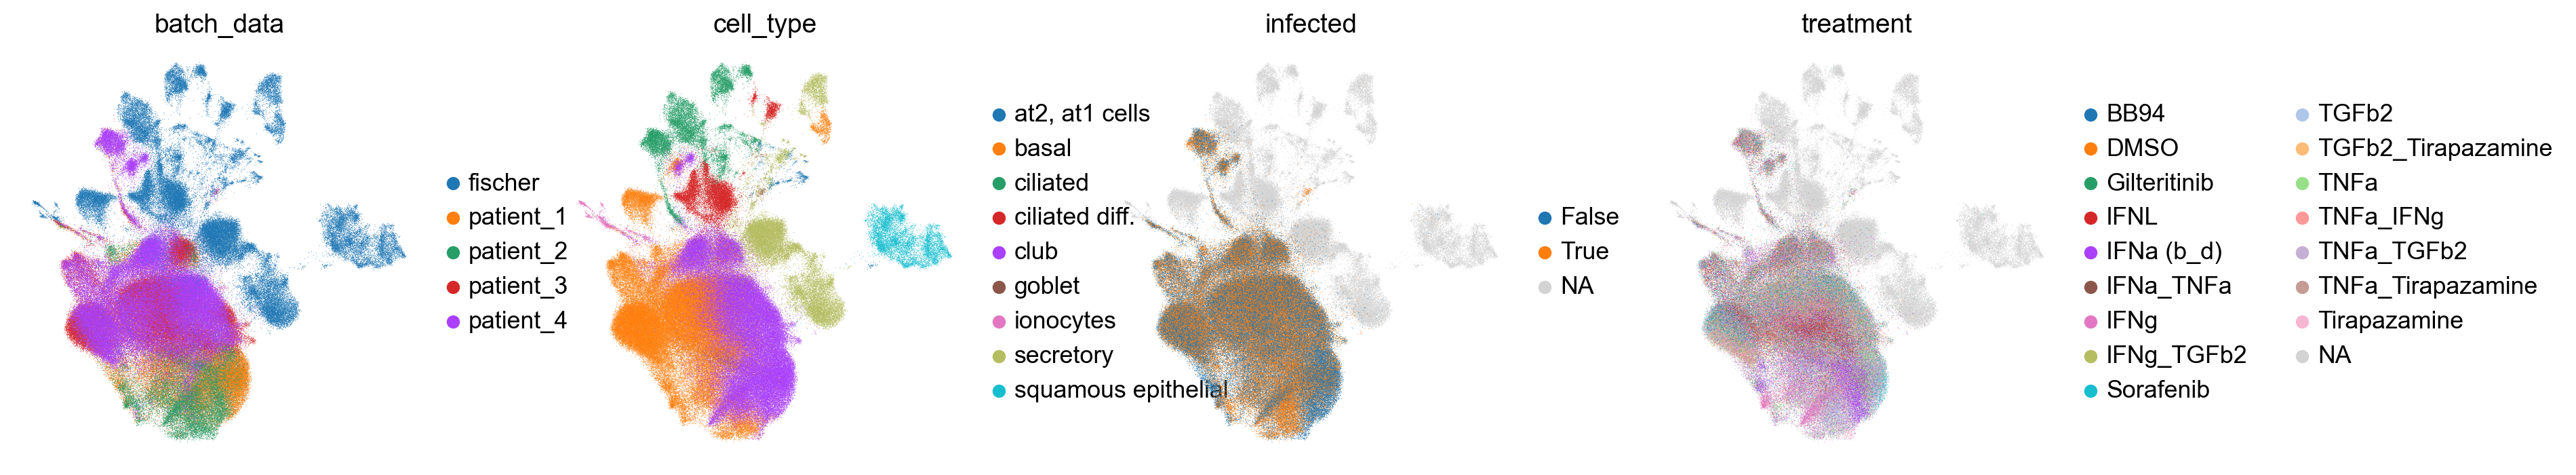

In [25]:
sc.pl.umap(adata, color=['batch_data', 'cell_type', 'infected', 'treatment'])

Save.

In [27]:
vae.save('2021-10-10_scvi_vae_patient_fischer_map', overwrite=True)

## scANVI label transfer

In [16]:
# vae = scvi.model.SCVI.load('2021-10-10_scvi_vae_patient_fischer_map', adata)

In [ ]:
adata.obs["treatment_scanvi"] = 'Unknown'
fischer_idx = adata.obs['batch_data'] != "fischer"
adata.obs["treatment_scanvi"][fischer_idx] = adata.obs.treatment[fischer_idx]

In [ ]:
adata.obs["treatment_scanvi"].value_counts()

In [ ]:
scvi.model.SCANVI.setup_anndata(
    adata,
    layer="counts",
    batch_key="batch_data",
    labels_key="treatment_scanvi",
)

In [ ]:
lvae = scvi.model.SCANVI.from_scvi_model(vae, "Unknown", adata=adata)

In [ ]:
lvae.train(max_epochs=20, n_samples_per_label=100)

In [28]:
adata.obs["treatment_predicted"] = lvae.predict(adata)
adata.obsm["X_scANVI"] = lvae.get_latent_representation(adata)

/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/scvi/model/base/_base_model.py:151: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  "Make sure the registered X field in anndata contains unnormalized count data."


In [29]:
sc.pp.neighbors(adata, use_rep="X_scANVI")
sc.tl.umap(adata)

/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'severity_virus' as categorical


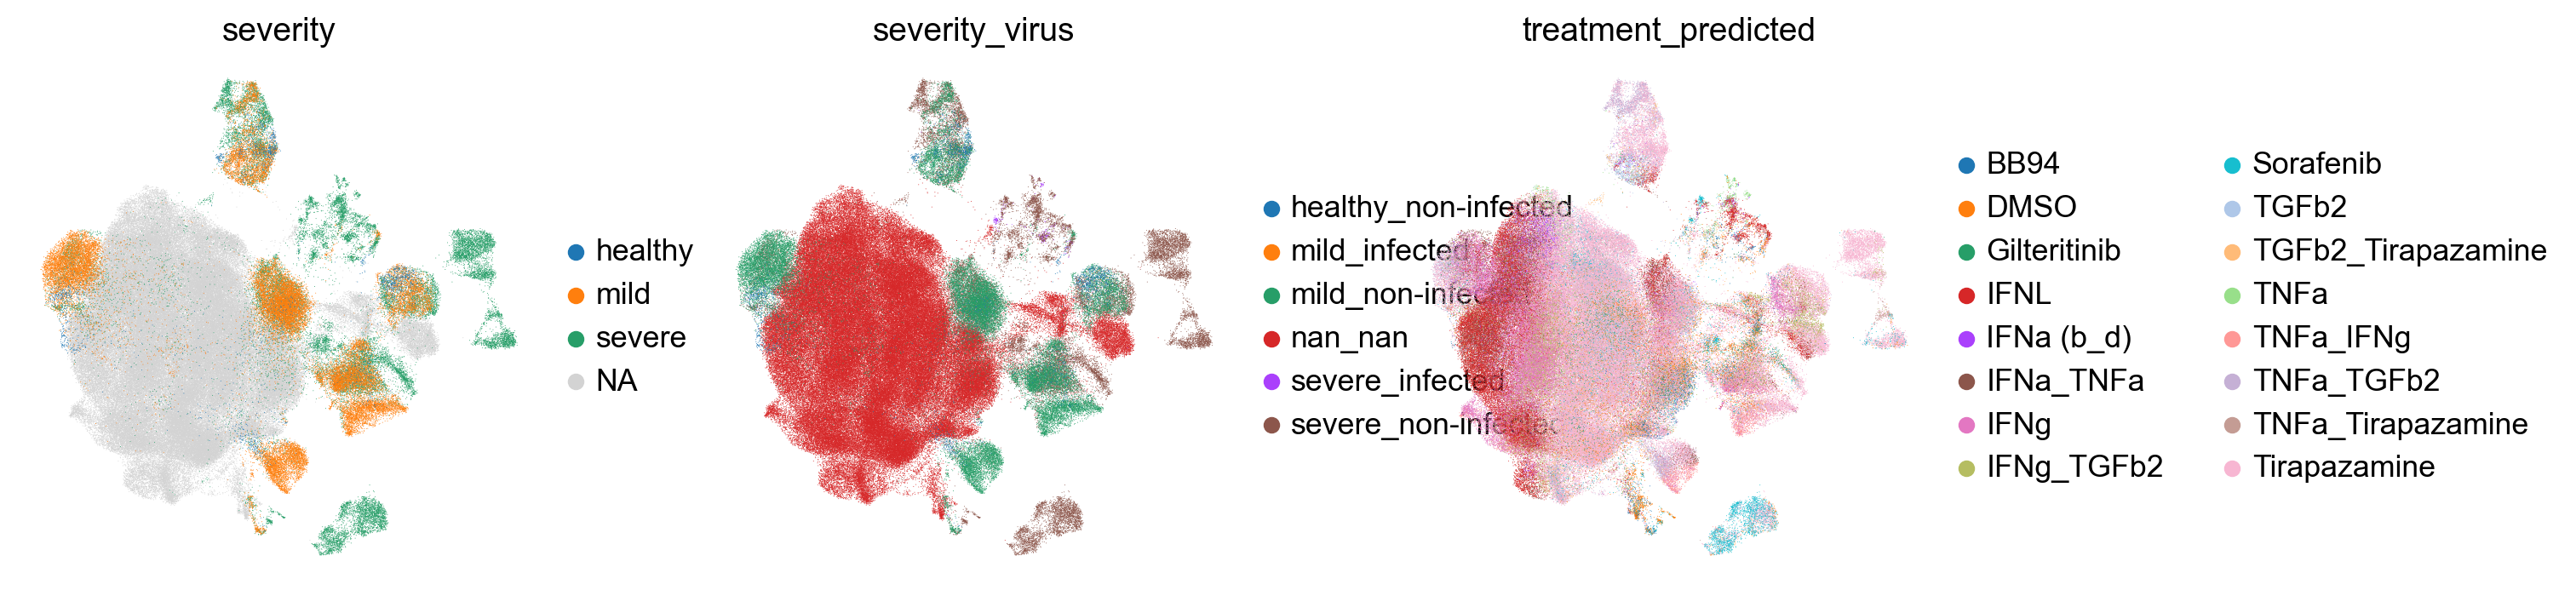

In [48]:
adata.obs['severity_virus'] = adata.obs.severity.astype(str) + '_' + adata.obs.virus_positive.astype(str)
sc.pl.umap(adata, color=['severity', 'severity_virus', 'treatment_predicted'])

Confusion matrix of patient qualities and treatment labels.

<AxesSubplot:xlabel='severity_virus', ylabel='treatment_predicted'>

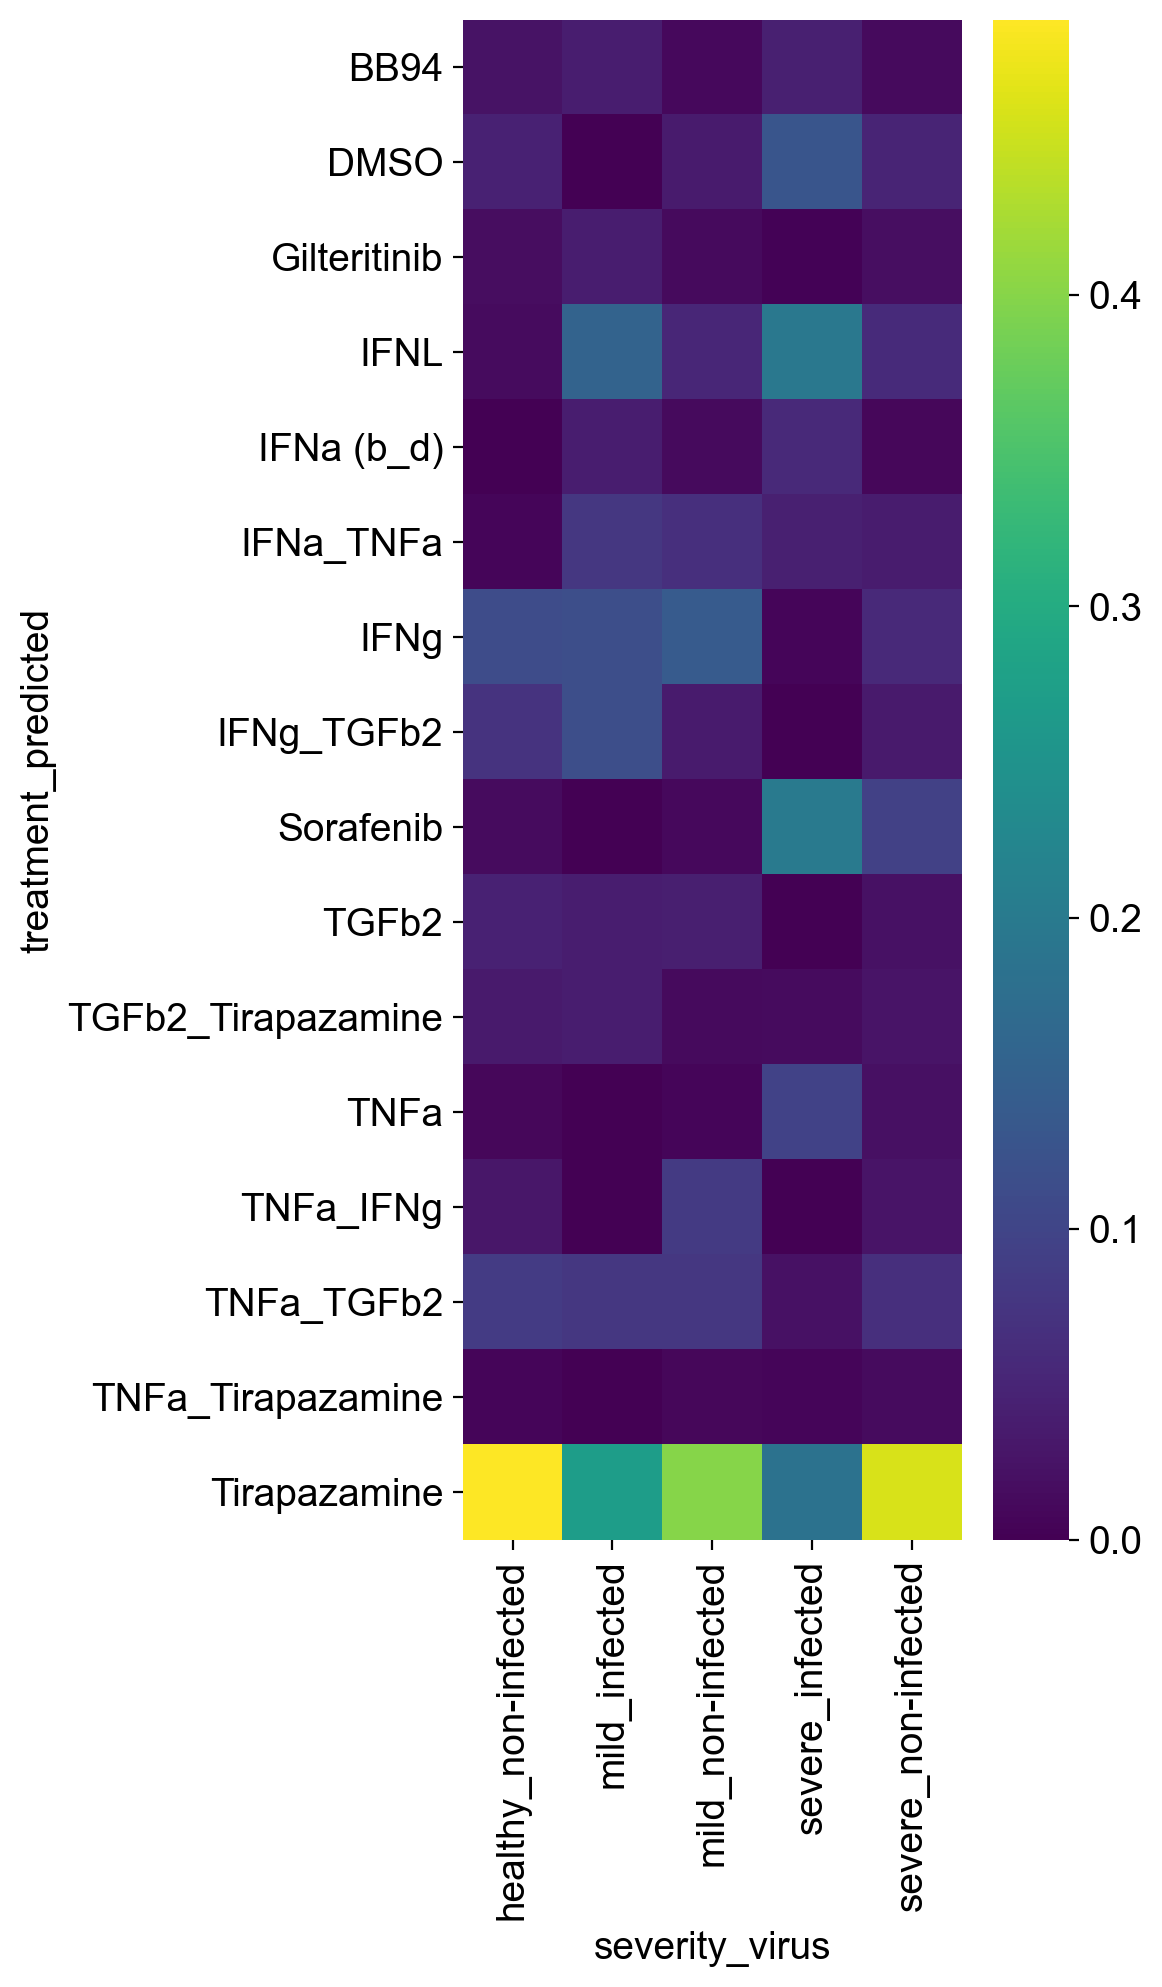

In [55]:
# normalized on columns
df = adata.obs.groupby(["severity_virus", "treatment_predicted"]).size().unstack(fill_value=0).T
df = df / df.sum(axis=0)
plt.figure(figsize=(4, 10))
sns.heatmap(df.drop(labels=['nan_nan'], axis=1), cmap='viridis')

## Save

In [56]:
sc.write('/storage/groups/ml01/workspace/yuge.ji/covid-perturbation/data/211005_fischer_integrated.h5ad', adata)

In [57]:
lvae.save('2021-10-10_scanvi_lvae_patient_fischer_labels')